In [10]:
from utilities import time_evolve
from Species import Ca40
from construct_H_tree import construct_H_tree
from structures import Laser, Chamber, Chain

from math import sqrt
import numpy as np

ion = Ca40([("S1/2", -1/2, "g"), ("S1/2", 1/2, "e"), ("P1/2", 1/2, "3")])

# Laser 1 should be sigma_+ polarized
laser1 = Laser(phi=np.pi/2, k_hat=np.array([1,0,1])/sqrt(2), eps_hat = 
               np.array([1, 1, 0])/sqrt(2))

# Laser 2 should be pi polarized
laser2 = Laser(phi=np.pi, k_hat=np.array([1,0,1])/sqrt(2), eps_hat = 
               np.array([0, 0, 1]))

chain = Chain([ion], trap_freqs=[3e6, 3e6, 1e6], selected_modes=[])

mode = chain.modes[-1]
mode.modecutoff(2)

chain.selected_modes = [mode] # consider one mode

chamber = Chamber(chain = chain, lasers = [laser1, laser2], 
                  B = 3.5928e-4, Bhat = np.array([-1,0,1])/sqrt(2))

chamber.set_laser_wavelength_from_transition(0, ion.transition(("g", "3")))
chamber.set_laser_wavelength_from_transition(1, ion.transition(("e", "3")))

Delta = -180 * 1e9
laser1.detune(Delta)
delta = 0#2.5e5
laser2.detune(Delta - delta)

ns = 1e-9
pt_1 = 1.67 * ns
pt_2 = 1.67 * ns

chamber.set_laser_intensity_from_pi_time(0, pt_1, ion.transition(("g", "3")))
chamber.set_laser_intensity_from_pi_time(1, pt_2, ion.transition(("e", "3")))

if Delta:
    raman_rabi = (np.pi**2)/(2*abs(Delta)*2*np.pi*pt_1*pt_2)
    pi_time_tot = np.pi/raman_rabi
    print("Expected Raman pi time:", pi_time_tot/1e-6 ,  "us")

timescale = 1e-6

H = construct_H_tree(chamber, timescale)
H.apply_adiabatic_elimination(threshold = 1e-4)

H.apply_ld_and_rwa_approximations(n_cutoff = mode.N, ld_cond_th = 1e-2, rwa_cutoff='inf')


Expected Raman pi time: 2.008008 us
Transformations:
(2, 0) -> (1, 0) in ion 0.
Expanding to 1st order in the Lamb-Dicke approximation


10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.1%. Run time:   0.05s. Est. time left: 00:00:00:00
60.1%. Run time:   0.06s. Est. time left: 00:00:00:00
70.1%. Run time:   0.07s. Est. time left: 00:00:00:00
80.1%. Run time:   0.07s. Est. time left: 00:00:00:00
90.1%. Run time:   0.08s. Est. time left: 00:00:00:00
100.0%. Run time:   0.08s. Est. time left: 00:00:00:00
Total run time:   0.08s


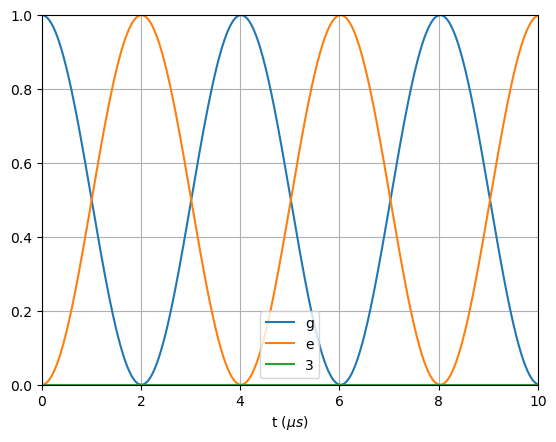

In [11]:
from qutip import tensor
duration = 10

times = np.linspace(0, duration, 1000)

psi_ion = ion.state['g']
psi_mot = mode.setstate(2)

psi_0 = tensor(psi_ion, psi_mot)

op1 = chain.ion_projector(1, "g") # project first ion onto "S-" level

op2 = chain.ion_projector(1, "e") # project first ion onto "S+" level

op3 = chain.ion_projector(1, "3") # project first ion onto "P" level

results = time_evolve(H, psi_0, times, expt_ops=[op1, op2, op3], progress_bar= True)
results.quick_plot()